In [17]:
!pip install open3d

ERROR: Could not find a version that satisfies the requirement open3d_tutorial (from versions: none)
ERROR: No matching distribution found for open3d_tutorial


## Running the ICP

In [3]:
import open3d as o3d
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
def draw_registration_result(source, target, transformation):
    source_temp = source.clone()
    target_temp = target.clone()

    source_temp.transform(transformation)

    # This is patched version for tutorial rendering.
    # Use `draw` function for you application.
    o3d.visualization.draw_geometries(
        [source_temp.to_legacy(),
         target_temp.to_legacy()],
        zoom=0.4459,
        front=[0.9288, -0.2951, -0.2242],
        lookat=[1.6784, 2.0612, 1.4451],
        up=[-0.3402, -0.9189, -0.1996])

In [5]:
treg = o3d.t.pipelines.registration
estimation = treg.TransformationEstimationPointToPlane()
criteria = treg.ICPConvergenceCriteria(relative_fitness=0.0001,
                                       relative_rmse=0.0001,
                                       max_iteration=1000)
voxel_size = 0.1
callback_after_iteration = lambda updated_result_dict : print("Iteration Index: {}, Fitness: {}, Inlier RMSE: {},".format(
    updated_result_dict["iteration_index"].item(),
    updated_result_dict["fitness"].item(),
    updated_result_dict["inlier_rmse"].item()))

max_correspondence_distance = 1
s = time.time()
transformations = []
time_per_frame = []
inlier_per_frame = []
target = o3d.t.io.read_point_cloud("dataset/map.pcd")
target.estimate_normals()
target.point["colors"] =  np.array([0, 0, 0]) / 255.0

In [6]:
for i in range(1014):
    source = o3d.t.io.read_point_cloud("dataset/frames/frame_"+str(i)+".pcd")
    source.point["colors"] = np.array([0, 255, 0]) / 255.0
    si = time.time()
    if i == 0:
        init_source_to_target = np.asarray([[0.862, 0.011, -0.507, 0.3],
                                            [-0.139, 0.967, -0.215, 0.3],
                                            [0.487, 0.255, 0.835, 0.3],
                                            [0.0, 0.0, 0.0, 1.0]])
    else:   
        init_source_to_target = registration_icp.transformation

    registration_icp = treg.icp(source, target, max_correspondence_distance,
                                init_source_to_target, estimation, criteria,
                                voxel_size)

    transformations.append(registration_icp.transformation)
    time_per_frame.append(time.time() - si)
    inlier_per_frame.append(registration_icp.inlier_rmse)

icp_time = time.time() - s
print("Time taken by ICP: ", icp_time)

Time taken by ICP:  156.601224899292


## Here we call the frame we are interested to check

In [7]:
frame = 960
T = transformations[frame]
target = o3d.t.io.read_point_cloud("dataset/map.pcd")
source = o3d.t.io.read_point_cloud(f"dataset/frames/frame_{frame}.pcd")
source.point["colors"] = np.array([0, 255, 0]) / 255.0
target.point["colors"] =  np.array([0, 0, 0]) / 255.0
source_temp = source.clone()
target_temp = target.clone()
source_temp.transform(T)


PointCloud on CPU:0 [11395 points (Float32)].
Attributes: colors (dtype = Float64, shape = {3}).

### Visualize point cloud

In [21]:
o3d.visualization.draw([source_temp,target_temp])
draw_registration_result(source, target_temp, T)

FEngine (64 bits) created at 0x179b00000 (threading is enabled)
FEngine resolved backend: OpenGL


[error] GLFW error: Cocoa: Failed to find service port for display


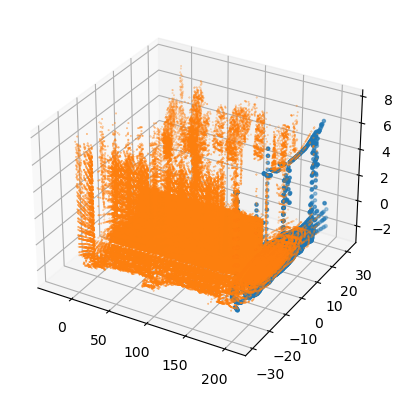

In [8]:
points = np.asarray(source_temp.point["positions"].numpy())
m_pint = np.asarray(target_temp.point["positions"].numpy())
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
ax.scatter(m_pint[:, 0], m_pint[:, 1], m_pint[:, 2], s=0.1)
plt.show()

<IPython.core.display.Javascript object>


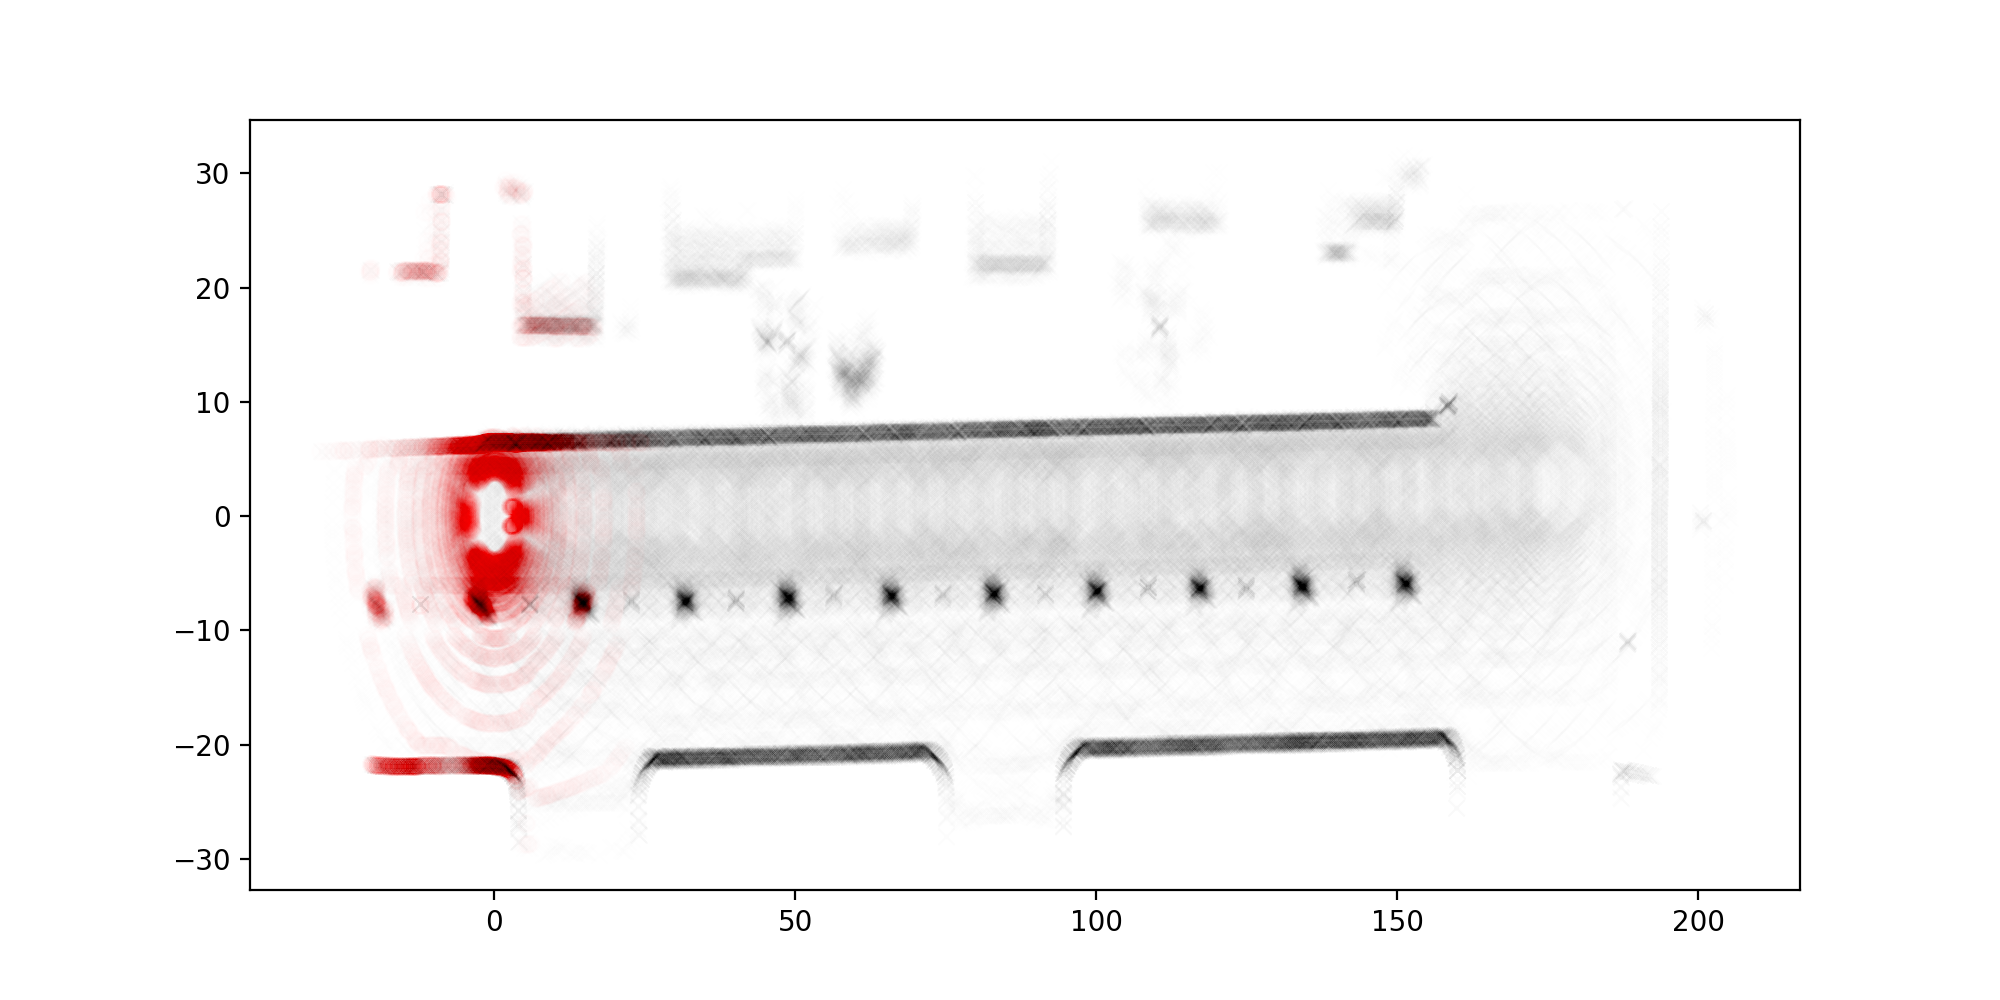

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import open3d as o3d
%matplotlib inline
%matplotlib notebook

m_pint = np.asarray(target_temp.point["positions"].numpy())

# Define the update function
def update(frame):
    global m_pint, transformations
    
    # Load the point cloud for the current frame and transform it
    source = o3d.t.io.read_point_cloud(f"dataset/frames/frame_{frame}.pcd")
    source.point["colors"] = np.array([0, 255, 0]) / 255.0
    source_temp = source.clone()
    source_temp.transform(transformations[frame])
    points = np.asarray(source_temp.point["positions"].numpy())
    
    # Clear the previous plot and display the updated points
    ax.clear()
    ax.plot(m_pint[:, 0], m_pint[:, 1], 'x', color='black', alpha=0.005)
    ax.plot(points[:, 0], points[:, 1], 'o', color='red', alpha=0.005)
    
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5))

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=1014, interval=10)

# Display the plot
plt.show()


In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('animation.mp4', writer=writer)

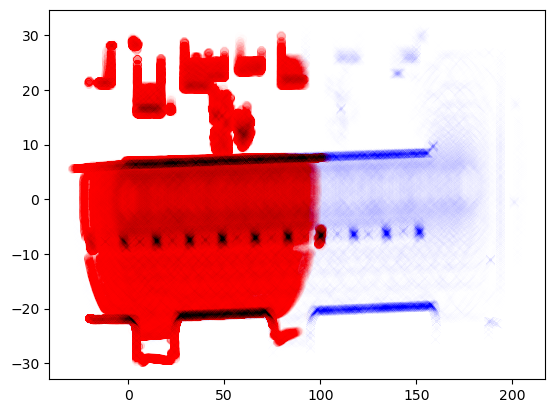

In [33]:
fig = plt.figure()
plt.plot(m_pint[:, 0], m_pint[:, 1], 'x', color='blue', alpha=0.005)

for i in range(400):

    T = transformations[i]
    source = o3d.t.io.read_point_cloud(f"dataset/frames/frame_{i}.pcd")
    source.point["colors"] = np.array([0, 255, 0]) / 255.0
    source_temp = source.clone()
    source_temp.transform(T)
    points = np.asarray(source_temp.point["positions"].numpy())
    plt.plot(points[:, 0], points[:, 1], 'o', color='red', alpha=0.005)
plt.show()

In [12]:
import csv
import torch

filename = 'out.csv'
header = ['Frame','x' ,'y' ,'z']
with open(filename, 'w', newline='') as csv_file:

    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(header)
    for i in range(len(transformations)):
        l = transformations[i][:-1,-1]
        array = l.numpy()
        values = array.tolist()
        values.insert(0,i)
        # Write the data to the file
        csv_writer.writerow(values)

## Metrics

In [13]:
out_df = pd.read_csv("out.csv")
gt_df = pd.read_csv("ground_truth.csv")

gt = gt_df.iloc[:, 1:3].to_numpy()
out = out_df[['x','y']].to_numpy()

### Max distance error

In [14]:
error = []
for idx in range(1014):
    e = np.linalg.norm(out[idx] - gt[idx])
    error.append(e)
print(max(error))

0.44023766527520636


### Mean distance error

In [15]:
e_value = sum(error) / len(error)
print(e_value)

0.14993673361716658


### Average time per frame

In [16]:
t_value = sum(time_per_frame) / len(time_per_frame)
print(t_value)

0.1431930786994317


In [17]:
print("Time taken by ICP: ", icp_time)

Time taken by ICP:  156.601224899292


### Average inlier_rmse per frame

In [18]:
rms_value = sum(inlier_per_frame) / len(inlier_per_frame)
print(rms_value)


0.19904509151150238
